In [188]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
import glob
import warnings

import numpy as np
from scipy import interpolate

from astropy.table import Table

import matplotlib.pyplot as plt
from matplotlib import rcParams

warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [193]:
def aper_masses(gal):
    """Summarize the aperture masses of a galaxy."""
    summary = {}
    
    # Central flag
    summary['cen'] = gal['info']['cen_flag']
    # Total stellar mass
    summary['logms'] = gal['info']['logms']
    # Total halo mass
    summary['logmh'] = gal['info']['logm200c']
    
    intrp1d = interpolate.interp1d(
        gal['prof']['gal_mprof']['sma'], gal['prof']['gal_mprof']['growth_ori'])
    
    summary['logms_10'] = np.log10(intrp1d(10.))
    summary['logms_15'] = np.log10(intrp1d(15.))
    summary['logms_30'] = np.log10(intrp1d(30.))
    summary['logms_50'] = np.log10(intrp1d(50.))
    summary['logms_100'] = np.log10(intrp1d(100.))
    
    # Also get the aperture ex-situ mass
    intrp1d_exs = interpolate.interp1d(
        gal['prof']['exs_mprof']['sma'], gal['prof']['exs_mprof']['growth_ori'])
    
    summary['logms_exs_10'] = np.log10(intrp1d_exs(10.))
    summary['logms_exs_15'] = np.log10(intrp1d_exs(15.))
    summary['logms_exs_30'] = np.log10(intrp1d_exs(30.))
    summary['logms_exs_50'] = np.log10(intrp1d_exs(50.))
    summary['logms_exs_100'] = np.log10(intrp1d_exs(100.))
    
    rad = gal['prof']['gal_mprof']['r_kpc']
    intens = gal['prof']['gal_mprof']['intens']
    axis_ratio = (1.0 - gal['prof']['gal_mprof']['ell'])
    summary['m_0'] = np.pi * axis_ratio[0] * intens[0] * (rad[0] ** 2)
    
    intrp2d = interpolate.interp1d(
        gal['aper']['rad_out'], gal['aper']['maper_gal'])
    
    summary['logms_10_aper'] = np.log10(intrp2d(10.))
    summary['logms_15_aper'] = np.log10(intrp2d(15.))
    summary['logms_30_aper'] = np.log10(intrp2d(30.))
    summary['logms_50_aper'] = np.log10(intrp2d(50.))
    summary['logms_100_aper'] = np.log10(intrp2d(100.))
    
    return summary

def get_cog(rad, intens, axis_ratio=1.0):
    """Measure curve of growth."""
    # Area within each aperture
    assert rad.shape == intens.shape
    aper_area = np.pi * axis_ratio * (rad ** 2)
    return np.cumsum(np.append(aper_area[0], np.diff(aper_area)) * intens)
    
def ellipseGetGrowthCurve(ellipOut, bkgCor=False, intensArr=None,
                          useTflux=False):
    """
    Extract growth curve from Ellipse output.
    Parameters:
    """
    if not useTflux:
        # The area in unit of pixels covered by an elliptical isophote
        ellArea = np.pi * ((ellipOut['sma'] ** 2.0) * (1.0 - ellipOut['ell']))
        # The area in unit covered by the "ring"
        # isoArea = np.append(ellArea[0], [ellArea[1:] - ellArea[:-1]])
        # The total flux inside the "ring"
        if intensArr is None:
            if bkgCor:
                intensUse = ellipOut['intens_sub']
            else:
                intensUse = ellipOut['intens']
        else:
            intensUse = intensArr
        try:
            isoFlux = np.append(
                ellArea[0], [ellArea[1:] - ellArea[:-1]]) * intensUse
        except Exception:
            isoFlux = np.append(
                ellArea[0], [ellArea[1:] - ellArea[:-1]]) * ellipOut['intens']
        # Get the growth Curve
        curveOfGrowth = np.asarray(
            list(map(lambda x: np.nansum(isoFlux[0:x + 1]), range(isoFlux.shape[0]))))
    else:
        curveOfGrowth = ellipOut['tflux_e']

    indexMax = np.argmax(curveOfGrowth)
    maxIsoSma = ellipOut['sma'][indexMax]
    maxIsoFlux = curveOfGrowth[indexMax]

    return curveOfGrowth, maxIsoSma, maxIsoFlux

In [190]:
#hsc_cat = Table.read(
#    '/Users/song/astro5/massive/dr16a/sbp/catalog/s16a_wide2_massive_fsps1_mass_use_sbp_cog.fits')

# New
hsc_cat = Table.read(
    '/Users/song/astro5/massive/dr16a/sbp/catalog/s16a_wide2_massive_fsps1_profile_good.fits')

rsma = np.arange(0.4, 4.20, 0.01)

hsc_mask_1 = ((hsc_cat['logm_100'] >= 11.4) & (hsc_cat['logm_100'] <= 11.6) &
              (hsc_cat['logm_100'] - hsc_cat['logm_10'] >= 0.03) &
              (hsc_cat['logm_10'] >= 10.9) & (hsc_cat['clean_photometry']))

hsc_mask_2 = ((hsc_cat['logm_100'] >= 11.6) & (hsc_cat['logm_100'] <= 11.8) &
              (hsc_cat['logm_100'] - hsc_cat['logm_10'] >= 0.03) &
              (hsc_cat['logm_10'] >= 11.0) & (hsc_cat['clean_photometry']))

hsc_mask_3 = ((hsc_cat['logm_100'] >= 11.8) & (hsc_cat['logm_100'] <= 12.2) &
              (hsc_cat['logm_100'] - hsc_cat['logm_10'] >= 0.03) &
              (hsc_cat['logm_10'] >= 11.1) & (hsc_cat['clean_photometry']))

print(hsc_mask_1.sum(), hsc_mask_2.sum(), hsc_mask_3.sum())

prof_hsc_bin_1 = np.nanmedian(hsc_cat[hsc_mask_1]['sbp'], axis=0)
prof_hsc_bin_2 = np.nanmedian(hsc_cat[hsc_mask_2]['sbp'], axis=0)
prof_hsc_bin_3 = np.nanmedian(hsc_cat[hsc_mask_3]['sbp'], axis=0)

7904 2187 351


In [14]:
tng_dir = '/Users/song/astro5/massive/simulation/riker/tng/sum'

xy_list = glob.glob(os.path.join(tng_dir, '*xy_sum.npy'))
xz_list = glob.glob(os.path.join(tng_dir, '*xz_sum.npy'))
yz_list = glob.glob(os.path.join(tng_dir, '*yz_sum.npy'))

print("# There are %d TNG massive galaxies" % len(xy_list))

xy_sum = [np.load(gal, allow_pickle=True) for gal in xy_list]
xz_sum = [np.load(gal, allow_pickle=True) for gal in xz_list]
yz_sum = [np.load(gal, allow_pickle=True) for gal in yz_list]

# There are 296 TNG massive galaxies


In [117]:
aper_sum_xy = Table([aper_masses(gal) for gal in xy_sum])
aper_sum_xz = Table([aper_masses(gal) for gal in xz_sum])
aper_sum_yz = Table([aper_masses(gal) for gal in yz_sum])

2189
20


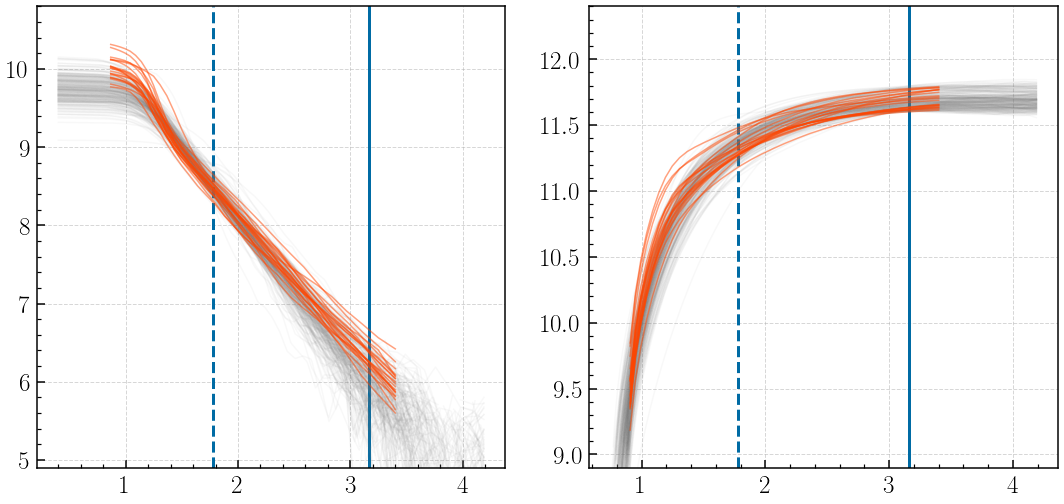

In [198]:
mass_0, mass_1 = 11.6, 11.8

hsc_mask = ((hsc_cat['logm_100'] >= mass_0) & (hsc_cat['logm_100'] <= mass_1) &
            (hsc_cat['logm_100'] - hsc_cat['logm_10'] >= 0.03) &
            (hsc_cat['logm_10'] >= 10.5) & (hsc_cat['clean_photometry']))

print(hsc_mask.sum())

fig_1 = plt.figure(figsize=(15, 7))
fig_1.subplots_adjust(left=0.05, bottom=0.08, right=0.995, top=0.995, 
                      wspace=0.18, hspace=0.17)

ax1 = fig_1.add_subplot(121)

ax1.axvline(10.0 ** 0.25, linestyle='--', linewidth=3)
ax1.axvline(100.0 ** 0.25, linestyle='-', linewidth=3)
for idx, hsc in enumerate(hsc_cat[hsc_mask]['sbp']):
    if idx % 9 == 0:
        ax1.plot(rsma, hsc, alpha=0.05, c='grey')

tng_bin_3 = []
for idx, tng in enumerate(xy_sum):
    if (aper_sum_xy[idx]['logms_100'] >= mass_0) and (aper_sum_xy[idx]['logms_100'] <= mass_1):
        tng_bin_3.append(tng)
        ax1.plot(tng['prof']['gal_mprof']['r_kpc'] ** 0.25, np.log10(tng['prof']['gal_mprof']['intens']), 
                 alpha=0.5, c='orangered')
print(len(tng_bin_3))

ax1.set_ylim(4.9, 10.8);
        
ax2 = fig_1.add_subplot(122)
ax2.axvline(10.0 ** 0.25, linestyle='--', linewidth=3)
ax2.axvline(100.0 ** 0.25, linestyle='-', linewidth=3)
for idx, hsc in enumerate(hsc_cat[hsc_mask]['cog']):
    if idx % 9 == 0:
        ax2.plot(rsma, hsc, alpha=0.05, c='grey')

for idx, tng in enumerate(xy_sum):
    if (aper_sum_xy[idx]['logms_100'] >= mass_0) and (aper_sum_xy[idx]['logms_100'] <= mass_1):
        ax2.plot(tng['prof']['gal_mprof']['r_kpc'] ** 0.25, np.log10(tng['prof']['gal_mprof']['growth_ori']), 
                 alpha=0.5, c='orangered')
        #ax2.plot(tng['aper']['rad_out'] ** 0.25, np.log10(tng['aper']['maper_gal']), c='forestgreen')
        
ax2.set_ylim(8.9, 12.4);

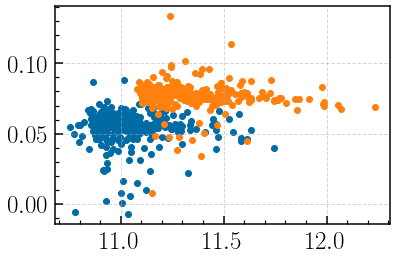

In [123]:
logm10_new = np.log10(10.0 ** aper_sum_xy['logms_10'] + aper_sum_xy['m_0'])
logm100_new = np.log10(10.0 ** aper_sum_xy['logms_100'] + aper_sum_xy['m_0'])

plt.scatter(aper_sum_xy['logms_10'], aper_sum_xy['logms_10_aper'] - logm10_new)
plt.scatter(aper_sum_xy['logms_100'], aper_sum_xy['logms_100_aper'] - logm100_new)